In [1]:
# Importing required libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
%matplotlib inline
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

In [185]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
from statsmodels.formula.api import ols
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

#### Reading the Data

In [2]:
df= pd.read_excel('Data_Train.xlsx')
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


#### Data Information

In [3]:
df.shape

(10683, 11)

 - Data has 10683 rows and 11 columns

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


- Need to convert Date_of_Journey to datetime
- Need to convert Total_stops to numeric variable
- Price is our target variable, making this a regression problem. 

In [5]:
pd.DataFrame({'Null Values': df.isnull().sum(), 'Null Percent': df.isnull().sum()/len(df)*100})

,Null Values,Null Percent
Airline,0,0.000000
Date_of_Journey,0,0.000000
Source,0,0.000000
Destination,0,0.000000
Route,1,0.009361
Dep_Time,0,0.000000
Arrival_Time,0,0.000000
Duration,0,0.000000
Total_Stops,1,0.009361
Additional_Info,0,0.000000


- Since we have only 1 missing value in the data, we can drop it. 

In [6]:
df1= df.dropna()
df1.shape

(10682, 11)

#### Changing Datatypes

In [7]:
df1['Date_of_Journey']= pd.to_datetime(df1['Date_of_Journey'])

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Airline          10682 non-null  object        
 1   Date_of_Journey  10682 non-null  datetime64[ns]
 2   Source           10682 non-null  object        
 3   Destination      10682 non-null  object        
 4   Route            10682 non-null  object        
 5   Dep_Time         10682 non-null  object        
 6   Arrival_Time     10682 non-null  object        
 7   Duration         10682 non-null  object        
 8   Total_Stops      10682 non-null  object        
 9   Additional_Info  10682 non-null  object        
 10  Price            10682 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(9)
memory usage: 1001.4+ KB


In [9]:
df1.Total_Stops.unique()

array(['non-stop', '2 stops', '1 stop', '3 stops', '4 stops'],
      dtype=object)

In [10]:
def stops(x):
    if x=='non-stop':
        return 0
    elif x=='2 stops':
        return 2
    elif x=='1 stop':
        return 1
    elif x=='3 stops':
        return 3
    else:
        return 4

In [11]:
df1.Total_Stops= df1.Total_Stops.apply(stops)

In [12]:
df1.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,0,No info,3897
1,Air India,2019-01-05,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2,No info,7662
2,Jet Airways,2019-09-06,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2,No info,13882
3,IndiGo,2019-12-05,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1,No info,6218
4,IndiGo,2019-01-03,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1,No info,13302


In [13]:
df1.Total_Stops.value_counts()

1    5625
0    3491
2    1520
3      45
4       1
Name: Total_Stops, dtype: int64

#### Checking Value Counts across the data

In [14]:
for i in df1.columns:
    print(i, df1[i].value_counts(), sep='\n')

Airline
Jet Airways                          3849
IndiGo                               2053
Air India                            1751
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64
Date_of_Journey
2019-05-18    504
2019-06-06    503
2019-05-21    497
2019-09-06    495
2019-12-06    493
2019-09-05    484
2019-03-21    423
2019-05-15    405
2019-06-03    403
2019-05-27    382
2019-06-27    355
2019-06-24    351
2019-01-06    342
2019-03-06    333
2019-06-15    328
2019-03-24    323
2019-03-03    315
2019-09-03    302
2019-03-27    299
2019-05-24    286
2019-06-05    281
2019-01-05    277
2019-12-05    259
2019-01-04    257
2019-01-03  

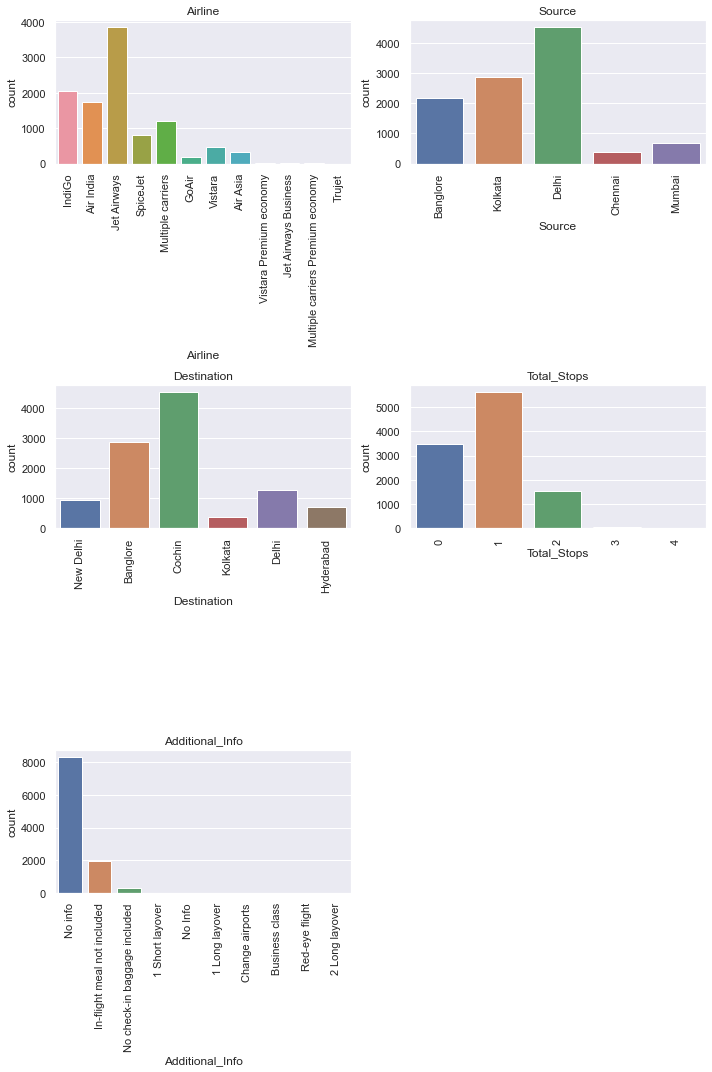

In [15]:
cat=df1[['Airline', 'Source', 'Destination','Total_Stops',
       'Additional_Info' ]] 

plt.rcParams['figure.figsize']=[10,15]
c=1
for i in cat.columns:
    plt.subplot(3,2,c)
    sns.countplot(df1[i])
    plt.xticks(rotation=90)
    plt.title(i)
    c+=1
    
plt.tight_layout()
plt.show()

- Jet Airways is most frequently travelled in
- Delhi is a popular source of travel while Cochin is a popular destination
- Most passengers opt for 1 stop flights
- We do not have additional information of most passengers 

#### Checking the target variable- Price

1.812404554693161


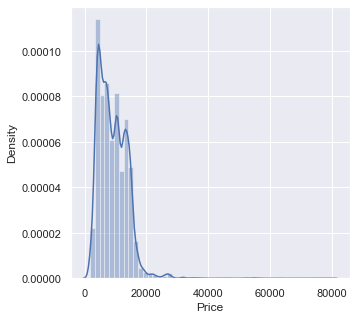

In [16]:
plt.rcParams['figure.figsize']=[5,5]
sns.distplot(df1.Price)
print(df1.Price.skew())

- As expected the price of airlines is right skewed

#### Exploratory Data Analysis

- We can extract information from the date of journey and create new features for more business sense

In [17]:
df1['Day']= df1.Date_of_Journey.dt.day

In [18]:
df1['Day_of_departure']= df1.Date_of_Journey.dt.day_name()

In [19]:
df1.Day.value_counts()

6     2166
5     1391
3     1361
27    1130
21    1111
24    1052
15     984
18     832
4      655
Name: Day, dtype: int64

- Categorize the days of the month as beginning, mid and end of month

In [29]:
def month_time(x):
    if x>=21 and x<30:
        return 'End'
    elif x>=15 and x<21:
        return 'Mid'
    elif x>=1 and x<15:
        return 'Beginning'
        

In [30]:
df1['Month']= df1.Day.map(month_time)

In [31]:
df1.head(2)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Day,Day_of_departure,Month
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,0,No info,3897,24,Sunday,End
1,Air India,2019-01-05,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2,No info,7662,5,Saturday,Beginning


In [32]:
df1.Month.value_counts()

Beginning    5573
End          3293
Mid          1816
Name: Month, dtype: int64

In [28]:
df1.Day_of_departure.value_counts()

Thursday     2290
Friday       1802
Wednesday    1598
Monday       1491
Tuesday      1236
Saturday     1203
Sunday       1062
Name: Day_of_departure, dtype: int64

- Splitting hours and minutes of duration

In [33]:
df1[['Hours', 'Minutes']]=df1.Duration.str.split(expand=True)

In [34]:
df1.head(2)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Day,Day_of_departure,Month,Hours,Minutes
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,0,No info,3897,24,Sunday,End,2h,50m
1,Air India,2019-01-05,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2,No info,7662,5,Saturday,Beginning,7h,25m


In [35]:
lst= []
for i in df1.Hours:
    lst.append(i[0:-1])

In [36]:
df1['Hours']=lst

In [37]:
df1.Minutes.fillna(0, inplace=True)

In [38]:
lst= []
for i in df1.Minutes:
    if i!=0:
        lst.append(i[0:-1])
    else:
        lst.append(i)

In [39]:
df1['Minutes']=lst

- Just taking the total minutes of flight duration would be easier

In [40]:
df1.Minutes.value_counts()

30    1446
0     1032
20     997
50     972
35     939
55     910
15     903
45     896
25     803
40     636
5      623
10     525
Name: Minutes, dtype: int64

In [41]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Airline           10682 non-null  object        
 1   Date_of_Journey   10682 non-null  datetime64[ns]
 2   Source            10682 non-null  object        
 3   Destination       10682 non-null  object        
 4   Route             10682 non-null  object        
 5   Dep_Time          10682 non-null  object        
 6   Arrival_Time      10682 non-null  object        
 7   Duration          10682 non-null  object        
 8   Total_Stops       10682 non-null  int64         
 9   Additional_Info   10682 non-null  object        
 10  Price             10682 non-null  int64         
 11  Day               10682 non-null  int64         
 12  Day_of_departure  10682 non-null  object        
 13  Month             10682 non-null  object        
 14  Hours             1068

In [42]:
df1[['Hours', 'Minutes']]=df1[['Hours', 'Minutes']].astype(int)

In [43]:
df1['Hours']=(df1['Hours']*60)

In [44]:
df1['Total_Minutes']=df1['Hours']+df1['Minutes']

In [45]:
df1.head(1)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Day,Day_of_departure,Month,Hours,Minutes,Total_Minutes
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,0,No info,3897,24,Sunday,End,120,50,170


- Dropping columns that we have extracted information from

In [46]:
df2= df1.drop(['Duration', 'Day', 'Hours', 'Minutes'], axis=1)

In [47]:
df2.head(2)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Total_Stops,Additional_Info,Price,Day_of_departure,Month,Total_Minutes
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,0,No info,3897,Sunday,End,170
1,Air India,2019-01-05,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,2,No info,7662,Saturday,Beginning,445


In [48]:
pd.options.display.max_rows= None

In [49]:
pd.options.display.max_columns= None

In [50]:
df1.Arrival_Time.value_counts()

19:00           423
21:00           360
19:15           333
16:10           154
12:35           122
20:45           112
22:30           111
18:50           111
22:50           104
11:20            95
19:50            94
21:20            90
12:20            87
22:25            77
21:05            72
23:35            71
20:05            69
14:05            68
08:35            67
12:00            63
19:45            60
23:00            57
07:15            56
12:55            55
13:15            54
18:10            54
11:25            54
19:40            53
10:40            53
08:45            53
15:30            53
22:00            52
10:10            51
22:35            51
22:55            50
19:35            50
07:45            49
12:10            49
18:15            49
09:30            49
21:50            49
10:05            49
16:20            49
13:55            49
11:50            49
04:25 07 Jun     48
10:35            48
08:50            48
23:15            46
22:20            45


In [51]:
df2.Arrival_Time[0][0:5]

'01:10'

In [52]:
lst_1= []

for i in df2.Arrival_Time:
    if len(i)>5:
        lst_1.append(i[0:5])
    else:
        lst_1.append(i)

In [53]:
df2.Arrival_Time= lst_1

In [54]:
df2.Arrival_Time.value_counts()

19:00    618
04:25    589
19:15    573
12:35    444
21:00    360
01:30    332
18:50    192
07:40    185
16:10    157
12:00    135
09:25    135
04:40    132
08:15    132
20:45    132
19:50    122
10:05    117
22:30    111
11:20    105
22:50    104
01:35    103
09:20    102
21:05    100
16:20     99
19:45     95
21:20     94
23:35     94
12:20     87
18:15     84
00:05     82
22:25     77
11:25     75
09:30     73
00:15     70
23:00     69
20:05     69
22:35     69
20:20     68
08:55     68
14:05     68
08:35     67
18:10     64
13:15     63
10:40     62
01:20     60
00:40     59
19:40     58
22:55     57
23:15     57
07:45     57
19:10     56
10:35     56
07:15     56
12:55     55
08:45     54
08:50     54
15:30     53
22:00     52
10:10     51
13:55     50
19:35     50
12:10     49
11:50     49
21:50     49
07:55     49
13:00     48
14:25     48
22:05     48
13:20     48
06:50     47
23:25     47
23:20     47
22:20     45
23:55     45
18:25     45
09:45     44
10:45     43
20:25     43

In [55]:
df2.Dep_Time.value_counts()

18:55    233
17:00    227
07:05    205
10:00    203
07:10    202
20:00    185
09:00    184
09:35    183
21:10    180
07:00    167
13:00    164
14:05    163
11:40    161
10:20    159
11:30    158
08:00    152
06:30    140
09:45    139
05:30    138
08:25    136
06:00    131
20:25    125
05:45    122
17:45    118
08:20    114
22:50    114
16:30    109
16:55    109
16:00    100
12:00     98
19:45     97
07:30     95
19:35     94
15:15     91
17:30     90
09:40     90
17:15     89
09:25     85
19:30     83
02:15     80
20:20     79
05:55     78
20:55     78
05:50     78
13:15     76
08:45     75
21:25     74
04:55     73
07:35     72
15:00     72
14:00     71
11:10     71
06:40     71
06:50     70
22:20     70
08:30     69
09:30     68
06:55     66
18:15     66
23:05     66
21:50     66
17:10     63
10:35     63
16:45     62
21:05     61
19:00     59
07:55     59
14:35     58
09:10     57
14:25     56
05:15     56
23:30     55
19:10     53
06:05     53
13:20     53
08:55     52
19:15     51

- Segregating the arrival and departure times in 4 time zones during the day : morning, afternoon, evening and night

In [56]:
def arri(x):
    lst = x.split(':')
    y = float(lst[0])
    if y >= 22 or y < 4:
        return 'Night'
    elif y >= 4 and y < 10:
        return 'Morning'
    elif y >= 10 and y < 16:
        return 'Afternoon'
    elif y >= 16 and y < 22:
        return 'Evening'
    
    

In [57]:
df2['Arrival']=df2['Arrival_Time'].map(arri)

In [58]:
df2['departure']=df2['Dep_Time'].map(arri)

In [59]:
df2.drop(['Arrival_Time', 'Dep_Time'], axis=1, inplace=True)

In [60]:
df2.head(4)

,Airline,Date_of_Journey,Source,Destination,Route,Total_Stops,Additional_Info,Price,Day_of_departure,Month,Total_Minutes,Arrival,departure
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,0,No info,3897,Sunday,End,170,Night,Night
1,Air India,2019-01-05,Kolkata,Banglore,CCU → IXR → BBI → BLR,2,No info,7662,Saturday,Beginning,445,Afternoon,Morning
2,Jet Airways,2019-09-06,Delhi,Cochin,DEL → LKO → BOM → COK,2,No info,13882,Friday,Beginning,1140,Morning,Morning
3,IndiGo,2019-12-05,Kolkata,Banglore,CCU → NAG → BLR,1,No info,6218,Thursday,Beginning,325,Night,Evening


- Dropping Route column as we already have source and destination variables
- Dropping Date_Of_Journey as we extracted relevant info from it

In [61]:
df2.drop(['Date_of_Journey', 'Route'], axis=1, inplace=True)

In [62]:
df2.head(3)

,Airline,Source,Destination,Total_Stops,Additional_Info,Price,Day_of_departure,Month,Total_Minutes,Arrival,departure
0,IndiGo,Banglore,New Delhi,0,No info,3897,Sunday,End,170,Night,Night
1,Air India,Kolkata,Banglore,2,No info,7662,Saturday,Beginning,445,Afternoon,Morning
2,Jet Airways,Delhi,Cochin,2,No info,13882,Friday,Beginning,1140,Morning,Morning


In [63]:
df2.shape

(10682, 11)

#### Correcting some categories within the data

In [85]:
df2.Destination.replace({'New Delhi':'Delhi'}, inplace=True)

In [87]:
df2.Additional_Info.replace({'No info':'No Info'}, inplace=True)

#### Bivariate Analysis

- Checking distribution of variables with price to look for insights 

In [88]:
var= df2[['Airline', 'Source', 'Destination', 'Additional_Info', 'Day_of_departure', 'Month',
         'Arrival', 'departure', 'Total_Stops']]

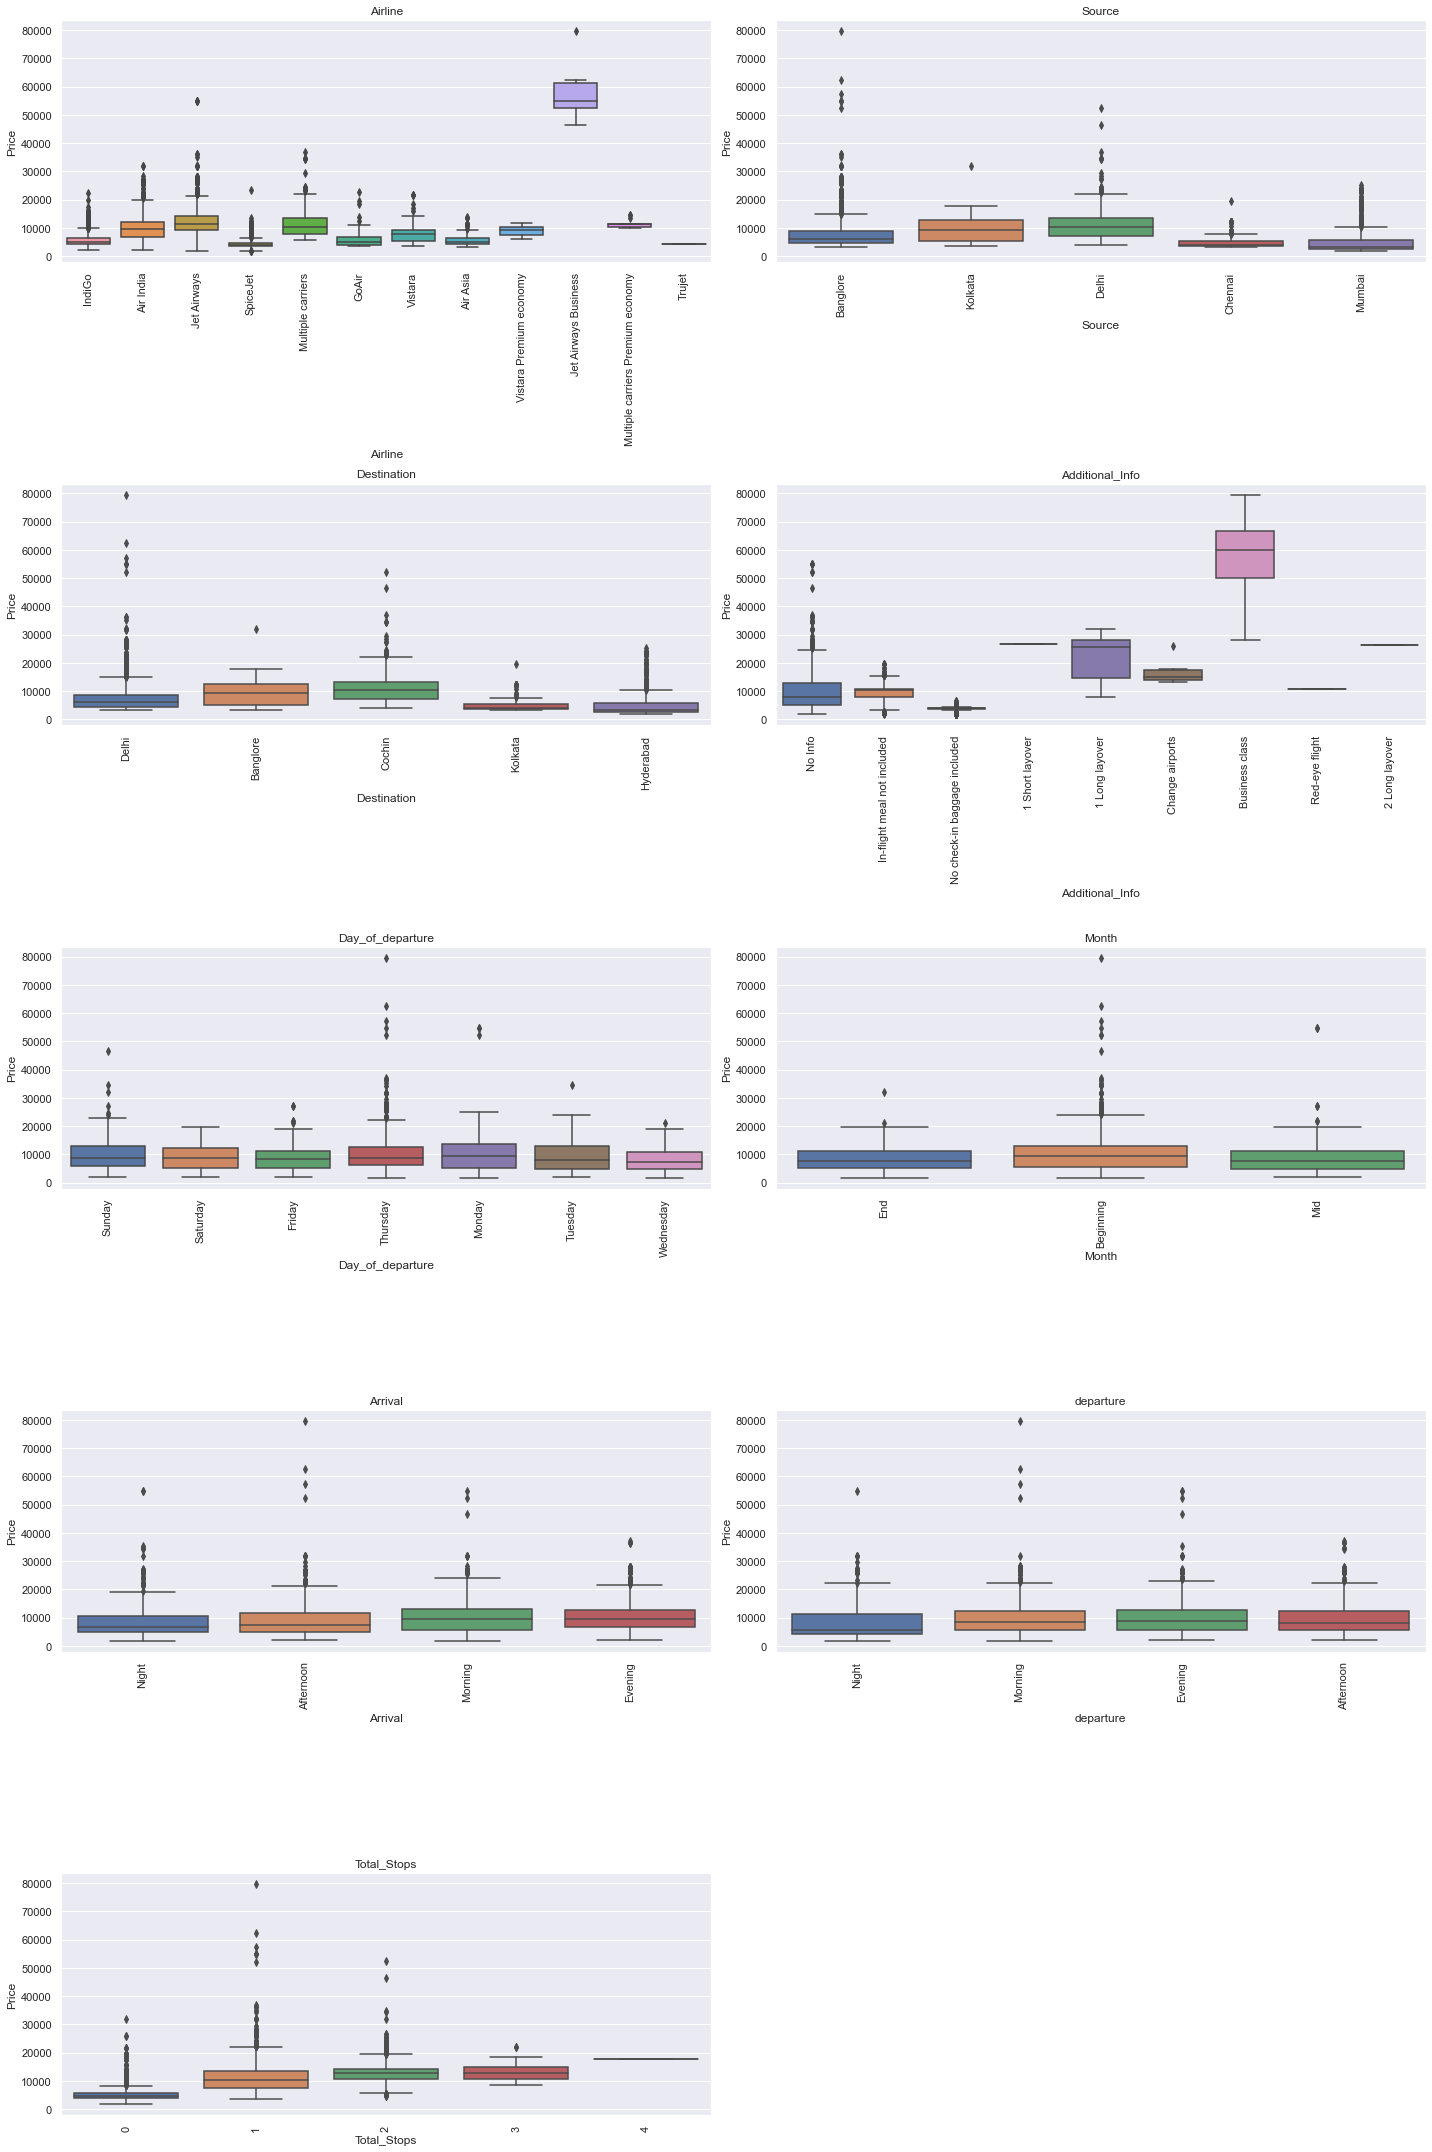

In [89]:
plt.rcParams['figure.figsize']=[20,30]
c=1
for i in var.columns:
    plt.subplot(5,2, c)
    sns.boxplot(x=df2[i], y=df2['Price'])
    plt.xticks(rotation=90)
    plt.title(i)
    c+=1
    
plt.tight_layout()
plt.show()

- The price of Jet Airways Premium in the Premium Category and Jet Airways is higher than other Airlines
- Flights are more expensive from Delhi as the source
- Cochin and Bangalore bound flights (destination) are more expensive
- Business Class and Long Layover flights have higher prices
- At the beginning of the month, prices are higher
- Flight prices at night on arrival or departure are less expensive
- As the total stops increase, the prices increase

<AxesSubplot:>

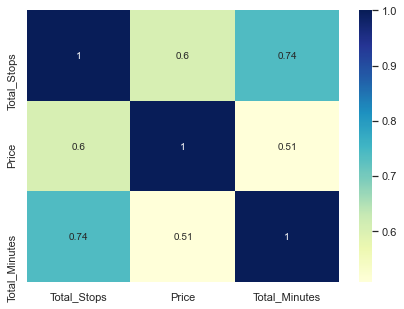

In [105]:
plt.rcParams['figure.figsize']=[7,5]
sns.heatmap(df2.corr(), annot=True, cmap='YlGnBu')

- There is positive correlation between total stops and price , strong positive correlation between total minutes and price
- This was found from the boxplot above too

#### Preparing Data for modelling

In [77]:
df2.head(3)

,Airline,Source,Destination,Total_Stops,Additional_Info,Price,Day_of_departure,Month,Total_Minutes,Arrival,departure
0,IndiGo,Banglore,New Delhi,0,No info,3897,Sunday,End,170,Night,Night
1,Air India,Kolkata,Banglore,2,No info,7662,Saturday,Beginning,445,Afternoon,Morning
2,Jet Airways,Delhi,Cochin,2,No info,13882,Friday,Beginning,1140,Morning,Morning


In [91]:
df_cat= df2[['Airline', 'Source', 'Destination', 'Additional_Info', 'Day_of_departure', 'Month', 'Arrival', 'departure']]
df_num=df2[['Total_Stops', 'Total_Minutes']]

In [92]:
dummy= pd.get_dummies(df_cat, drop_first=True)
dummy.shape

(10682, 41)

In [94]:
sc= StandardScaler()

df_scaled= pd.DataFrame(sc.fit_transform(df_num), columns=df_num.columns)
df_scaled.head()

,Total_Stops,Total_Minutes
0,-1.220666,-0.931601
1,1.741432,-0.390028
2,1.741432,0.978676
3,0.260383,-0.626351
4,0.260383,-0.705125


In [95]:
dummy.reset_index(drop=True, inplace=True)
df_scaled.reset_index(drop=True, inplace=True)

In [97]:
final= pd.concat([dummy,df_scaled], axis=1)
final.shape

(10682, 43)

In [100]:
X= final
y= df2['Price']

xtrain, xtest, ytrain, ytest= train_test_split(X, y, random_state=42, test_size=0.30)

print(xtrain.shape)
print(xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(7477, 43)
(3205, 43)
(7477,)
(3205,)


In [165]:
#Fitting the base model using linear regression from the sklearn library

lr= LinearRegression(fit_intercept=True)

base= lr.fit(xtrain, ytrain)

ypred_train= base.predict(xtrain)

ypred_test= base.predict(xtest)

print('Train R2 Score: ', r2_score(ytrain, ypred_train))
print('Test R2 Score: ', r2_score(ytest, ypred_test))

print('RMSE Train: ', np.sqrt(mean_squared_error(ytrain, ypred_train)))
print('RMSE Test: ', np.sqrt(mean_squared_error(ytest, ypred_test)))


Train R2 Score:  0.6789053507376337
Test R2 Score:  0.6733275148656173
RMSE Train:  2635.549670067785
RMSE Test:  2581.5540638753605


- The train and test R2 scores are very similar on the base model. 
- We try to see the significant variables and understand coefficients by using ols by statsmodels

In [163]:
#Fitting the base model using linear regression from the statsmodels library

X= sm.add_constant(X)
y=list(y)                   # converting y to a list to solve for the endog exog issue in statsmodels

x_train, x_test, y_train, y_test= train_test_split(X, y, test_size=0.30, random_state=42)

base_model = sm.OLS(y_train, x_train).fit()
base_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     405.4
Date:                Sun, 24 Apr 2022   Prob (F-statistic):               0.00
Time:                        01:02:23   Log-Likelihood:                -69491.
No. Observations:                7477   AIC:                         1.391e+05
Df Residuals:                    7437   BIC:                         1.393e+05
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                         2.258e+15   6.63e+15      0.341      0.733   -1.07e+16    1.52e+16
Airline_Air India                             1821.4075    205.709      8.854      0.000    1418.159    2224.656
Airline_GoAir                                  431.2240    288.381      1.495      0.135    -134.085     996.533
Airline_IndiGo                                 419.0954    193.478      2.166      0.030      39.823     798.368
Airline_Jet Airways                           6274.9488    200.045     31.368      0.000    5882.804    6667.093
Airline_Jet Airways Business                  4.031e+04   1538.755     26.200      0.000    3.73e+04    4.33e+04
Airline_Multiple carriers                     4166.8097    218.876     19.037      0.000    3737.750    4595.869
Airline_Multiple carriers Premium economy     5288.4596    790.890      6.687      0.000    3738.092    6838.827
Airline_SpiceJet                                81.8619    233.201      0.351      0.726    -375.278     539.002
Airline_Trujet                               -2715.9085   2653.235     -1.024      0.306   -7917.000    2485.183
Airline_Vistara                               2140.6768    235.406      9.094      0.000    1679.214    2602.140
Airline_Vistara Premium economy               4478.7836   2652.099      1.689      0.091    -720.080    9677.647
Source_Chennai                               -2.444e+15   3.25e+15     -0.752      0.452   -8.82e+15    3.93e+15
Source_Delhi                                 -1.275e+16   8.28e+15     -1.538      0.124    -2.9e+16    3.49e+15
Source_Kolkata                               -2.258e+15   6.63e+15     -0.341      0.733   -1.52e+16    1.07e+16
Source_Mumbai                                  -3.9e+15   3.49e+15     -1.117      0.264   -1.07e+16    2.95e+15
Destination_Cochin                            1.049e+16   9.56e+15      1.098      0.272   -8.24e+15    2.92e+16
Destination_Delhi                            -2.258e+15   6.63e+15     -0.341      0.733   -1.52e+16    1.07e+16
Destination_Hyderabad                         1.643e+15    4.2e+15      0.391      0.695   -6.58e+15    9.87e+15
Destination_Kolkata                           1.861e+14   3.63e+15      0.051      0.959   -6.92e+15    7.29e+15
Additional_Info_1 Short layover               5610.9736   2741.069      2.047      0.041     237.703     1.1e+04
Additional_Info_2 Long layover                5074.2471   2739.498      1.852      0.064    -295.944    1.04e+04
Additional_Info_Business class                 1.43e+04   2519.454      5.677      0.000    9364.332    1.92e+04
Additional_Info_Change airports              -4045.1362   1306.123     -3.097      0.002   -6605.506   -1484.766
Additional_Info_In-flight meal n

#### About the Model: 
- The R2 score of 0.68 tells us that 68% of the variability in the target variable (price) can be explained by our model
- There is a high Condition No. suggesting high multicollinearity among variables
- The Jarque Bera p value is less than 0.05 suggesting that the data is not normal
- There is no autocorrelation among residuals as can be seen from the Durbin Watson test

- The p values less of variables less than 0.05 indicate that the variables are significant to the model
- The negative coefficients suggest a negative relationship between the target variable and the particular predictors

#### Selecting best features

In [175]:
sfs_mod= sfs(estimator=lr, k_features='best', scoring='r2', cv=5, forward=True)

sfs_mod.fit(xtrain, ytrain)

print(sfs_mod.k_feature_names_)

('Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo', 'Airline_Jet Airways', 'Airline_Jet Airways Business', 'Airline_Multiple carriers', 'Airline_Multiple carriers Premium economy', 'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy', 'Source_Delhi', 'Source_Mumbai', 'Destination_Cochin', 'Destination_Hyderabad', 'Additional_Info_2 Long layover', 'Additional_Info_Business class', 'Additional_Info_In-flight meal not included', 'Additional_Info_No Info', 'Additional_Info_No check-in baggage included', 'Day_of_departure_Monday', 'Day_of_departure_Saturday', 'Day_of_departure_Sunday', 'Day_of_departure_Thursday', 'Day_of_departure_Tuesday', 'Day_of_departure_Wednesday', 'Month_End', 'Month_Mid', 'Arrival_Evening', 'departure_Morning', 'departure_Night', 'Total_Stops', 'Total_Minutes')


- SFS does not help much as all features seem to be important

#### Trying other algorithms

In [177]:
rf= RandomForestRegressor()

mod_2= rf.fit(xtrain, ytrain)

ypred1_train= mod_2.predict(xtrain)

ypred1_test= mod_2.predict(xtest)

print('Train R2 Score: ', r2_score(ytrain, ypred1_train))
print('Test R2 Score: ', r2_score(ytest, ypred1_test))

print('RMSE Train: ', np.sqrt(mean_squared_error(ytrain, ypred1_train)))
print('RMSE Test: ', np.sqrt(mean_squared_error(ytest, ypred1_test)))


Train R2 Score:  0.9494070769180368
Test R2 Score:  0.7795167850718494
RMSE Train:  1046.1634844594162
RMSE Test:  2120.863475031384


- Data is overfitted , we can tune the regressor using Grid Search

In [186]:
tuned_params= [{'max_depth':range(10,20), 'min_samples_split': range(10,20)}]

grid= GridSearchCV(estimator=rf, param_grid= tuned_params, scoring='r2', cv=5)

grid.fit(xtrain, ytrain)

print(grid.best_params_)

{'max_depth': 18, 'min_samples_split': 10}


In [187]:
#Using the Best Parameters

rf= RandomForestRegressor(max_depth=18, min_samples_split=10)

mod_rf= rf.fit(xtrain, ytrain)

ypred_rf_train= mod_rf.predict(xtrain)

ypred_rf_test= mod_rf.predict(xtest)

print('Train R2 Score: ', r2_score(ytrain, ypred_rf_train))
print('Test R2 Score: ', r2_score(ytest, ypred_rf_test))

print('RMSE Train: ', np.sqrt(mean_squared_error(ytrain, ypred_rf_train)))
print('RMSE Test: ', np.sqrt(mean_squared_error(ytest, ypred_rf_test)))


Train R2 Score:  0.8905933220335204
Test R2 Score:  0.8042926409772444
RMSE Train:  1538.425914149203
RMSE Test:  1998.1520118490387


- The data may still be slightly overfit as there is a difference of 9% in the train and test scores

In [181]:
gb= GradientBoostingRegressor()

mod_3= gb.fit(xtrain, ytrain)

ypred2_train= mod_3.predict(xtrain)

ypred2_test= mod_3.predict(xtest)

print('Train R2 Score: ', r2_score(ytrain, ypred2_train))
print('Test R2 Score: ', r2_score(ytest, ypred2_test))

print('RMSE Train: ', np.sqrt(mean_squared_error(ytrain, ypred2_train)))
print('RMSE Test: ', np.sqrt(mean_squared_error(ytest, ypred2_test)))


Train R2 Score:  0.7588477716916358
Test R2 Score:  0.759212637921888
RMSE Train:  2284.022147373539
RMSE Test:  2216.3675902215145


- Seems to work well as the data is not overfitted

In [182]:
sgd= SGDRegressor()

mod_4= sgd.fit(xtrain, ytrain)

ypred3_train= mod_4.predict(xtrain)

ypred3_test= mod_4.predict(xtest)

print('Train R2 Score: ', r2_score(ytrain, ypred3_train))
print('Test R2 Score: ', r2_score(ytest, ypred3_test))

print('RMSE Train: ', np.sqrt(mean_squared_error(ytrain, ypred3_train)))
print('RMSE Test: ', np.sqrt(mean_squared_error(ytest, ypred3_test)))

Train R2 Score:  0.6622419345186108
Test R2 Score:  0.6730730239240748
RMSE Train:  2703.0715117530613
RMSE Test:  2582.5594350808074


- Not much improvement from Linear Regression Model

In [184]:
dt= DecisionTreeRegressor()

mod_5= dt.fit(xtrain, ytrain)

ypred4_train= mod_5.predict(xtrain)

ypred4_test= mod_5.predict(xtest)

print('Train R2 Score: ', r2_score(ytrain, ypred4_train))
print('Test R2 Score: ', r2_score(ytest, ypred4_test))

print('RMSE Train: ', np.sqrt(mean_squared_error(ytrain, ypred4_train)))
print('RMSE Test: ', np.sqrt(mean_squared_error(ytest, ypred4_test)))

Train R2 Score:  0.9713012123421607
Test R2 Score:  0.691391827419364
RMSE Train:  787.9278415781159
RMSE Test:  2509.1617465991435


- Data is extremely overfitted, we can tune the Decision Tree using Grid Search 

#### Gradient Boosting Regressor does a good job on the train and test data as the r2 score has increased and the model is not overfitted. 

#### The RMSE is also lower than that of the linear regression model.